<a href="https://colab.research.google.com/github/is-leeroy-jenkins/BudgetPy/blob/master/ipynb/BalanceEstimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Account-Balance Projection Model
___
- Enhancing Federal Budget Forecasting through Statistical and Machine Learning Techniques
- A budget model for projecting federal account balances built with Generative AI (GPT-4o) and Machine Learning models.

##### Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

In [2]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

#### Data Source
- File A (Account Balances) published monthly by agencies on [USASpending](https://www.usaspending.gov/federal_account)
- Required by the DATA Act.
- Pulled automatically from data in the [Governmentwide Treasury Account Symbol Adjusted Trial Balance System (GTAS)](https://fiscal.treasury.gov/gtas/)
- Contains Budgetary resources, obligation, and outlay data for all the relevant Treasury Account Symbols (TAS) in a reporting agency.
- It includes both award and non-award spending (grouped together), and crosswalks with the [SF 133 report](https://portal.max.gov/portal/document/SF133/Budget/FACTS%20II%20-%20SF%20133%20Report%20on%20Budget%20Execution%20and%20Budgetary%20Resources.html).

#### Observations
- Each row appears to represent a specific account within an agency, identified by Treasury Account Symbol, Federal Account Symbol, and Agency Identifier.
- The period of availability for funds is stored as text, indicating beginning and ending dates.
- Various financial balances, including carryover authority, offsetting receipts, unobligated balances, and total resources, are stored as numerical values.
- The LastModified column records the timestamp of the last update to a record.
- The SubmissionPeriod column likely represents the reporting period.

## I. Introduction
Government budgeting is a highly complex process requiring accurate forecasting to allocate funds effectively, prevent deficits, and support economic stability. Traditional forecasting models, such as historical averages and linear regressions, have been widely used to project federal obligations, outlays, and appropriations. However, these approaches often fail to capture nonlinear relationships, seasonal variations, and policy-driven spending patterns.

Given the increasing complexity of federal financial management, there is a growing need for data-driven models that adapt to changing economic conditions and agency-specific fiscal behaviors. This study seeks to integrate machine learning and statistical modeling to enhance the predictive capabilities of federal budget forecasts.

This study aims to address the following key questions:

- What statistical patterns exist in federal budget data?
- How do machine learning models compare to traditional regression methods in forecasting agency spending?
- Which time-series forecasting techniques provide the most reliable budget projections?
By answering these questions, this research provides a modernized, data-driven approach to enhancing budget forecasting accuracy and strengthening fiscal policy planning.




#### Abstract

Federal budget forecasting plays a pivotal role in fiscal policy, ensuring that government agencies allocate resources efficiently while maintaining economic stability. However, traditional budget estimation methods rely on linear assumptions and historical trends, which often fail to capture the complexity and variability of government spending patterns. This study integrates advanced statistical techniques and machine learning models, including regression analysis, decision trees, and time-series forecasting, to improve budget prediction accuracy.

Our findings demonstrate that tree-based models (Gradient Boosting and Random Forest) outperform traditional linear regression approaches, while ARIMA and Holt-Winters models effectively capture spending trends over time. By leveraging descriptive statistics, feature engineering, and model optimization, we develop a comprehensive, data-driven framework for predicting federal outlays, appropriations, and obligations. The study's results underscore the necessity for modernized forecasting methods in government budgeting, offering improved fiscal decision-making capabilities for policymakers and financial analysts.

#### Background
The federal budget comprises various components, including obligations, outlays, and unobligated balances, each reflecting different aspects of government financial activities. Obligations represent commitments to spend, outlays are actual expenditures, and unobligated balances indicate remaining funds available for future use. Accurate forecasting of these elements is essential for effective fiscal management. The Office of Management and Budget (OMB) provides comprehensive data and analytical perspectives on federal finances, offering valuable insights into historical trends and future projections.

Federal Budget Components
The federal budget consists of multiple financial components, each reflecting different aspects of government spending:

- Appropriations: Funds allocated by Congress for specific purposes.
- Obligations: Legal commitments made by agencies to spend appropriated funds.
- Outlays: Actual expenditures paid by the Treasury.
- Unobligated Balances: Remaining funds that agencies can use in future fiscal years.
These components interact in nonlinear ways, making their prediction challenging. Traditional forecasting methods often assume linear relationships, but real-world spending patterns are influenced by policy changes, economic shifts, and emergency expenditures.

Challenges in Budget Forecasting
Variability in Spending Patterns: Some agencies spend their budgets evenly, while others have large end-of-year disbursements.
Economic and Policy Changes: Budget projections must account for shifts in GDP growth, inflation, and legislative changes.
Non-Normal Data Distributions: Federal budget data often exhibit skewness and outliers, making traditional parametric methods less effective.
Given these challenges, machine learning and statistical modeling provide more adaptable solutions for budget forecasting.

#### Problem
Traditional budget forecasting methods in federal agencies have significant limitations in accuracy, adaptability, and robustness. These methods typically rely on:

- Linear trend analysis, which assumes that spending behavior follows a predictable trajectory.
- Historical averages, which fail to account for policy changes, economic volatility, and shifts in agency priorities.
- Manual budget adjustments, which introduce human biases and lead to inefficiencies in fund allocation.
- These constraints often result in misallocation of funds, inefficient resource utilization, and budget shortfalls or surpluses. Federal agencies require more sophisticated forecasting models that account for non-linear trends, economic uncertainties, and multi-year budget fluctuations.

To address these issues, this study explores the use of machine learning models (Gradient Boosting, Random Forest) and time-series forecasting techniques (ARIMA, Holt-Winters) to:

- Capture non-linear financial relationships that traditional regression models fail to detect.
- Improve the accuracy of budget outlay predictions using advanced statistical approaches.
- Develop a data-driven framework for more effective federal fiscal planning.
By implementing these models, government agencies can enhance their financial forecasting accuracy, optimize budget allocations, and improve overall fiscal management.

#### Limitations
##### 1. Data Availability:
- The analysis relies on historical data, which may not fully capture real-time economic fluctuations or unforeseen events.
##### 2. Model Interpretability:
- Complex models, such as machine learning algorithms, may lack transparency, making it challenging for policymakers to understand the underlying mechanisms.
##### 3. Structural Changes:
- The models may not account for significant structural changes in the economy or fiscal policy, potentially affecting forecast accuracy.

## II. Methodologies
___
The study employs a comprehensive analytical approach, encompassing the following stages:


#### Data Collection & Processing:
- Cleaning and organizing data to address missing values and inconsistencies, ensuring readiness for analysis.
- The dataset underwent rigorous preprocessing to ensure the removal of missing values and inconsistencies.
- Missing values in key financial columns such as Unobligated Balance, Obligations, Outlays, and Total Resources were identified and handled appropriately using imputation techniques where applicable.
- Duplicate records were examined to ensure data integrity, and unnecessary columns were dropped to enhance analytical efficiency.
- Variables were assessed for data type correctness, and categorical variables were encoded where necessary to facilitate statistical computations.
- The dataset was filtered for missing values in key financial columns, ensuring accurate statistical analysis.
- The primary variables of interest were Unobligated Balance, Obligations, Outlays, and Total Resources, as these represent critical components of federal account balances.




#### Statistics & Probability Distributions

The research involved descriptive and inferential statistical methods to understand the dataset structure.

##### Statistical Analysis:

- Descriptive Statistics: Mean, standard deviation, skewness, and distributions of budget outlays.
- Hypothesis Testing: T-tests, ANOVA, and chi-square tests to examine year-over-year differences in budget allocations.
- Correlation Analysis: Pearson, Kendall’s Tau, and Spearman correlation coefficients to identify relationships between fiscal years.


#### Feature Engineering & Dimensionality Reduction:

- Min-Max Scaling & Z-score Standardization to normalize budget outlays.
- Principal Component Analysis (PCA) to reduce data complexity while retaining variance.
- K-Means Clustering & Factor Analysis to categorize spending patterns.

#### Regression Modeling
A range of machine learning regression techniques were applied to model budgetary trends:

- Linear Regression - Establishes a baseline trend model.
- Polynomial Regression - Captures nonlinear relationships between fiscal years.
- Ridge & Lasso Regression - Applies regularization to avoid overfitting.
- Bayesian Ridge Regression - Enhances robustness in high-noise datasets.
- Gradient Boosting & Random Forest - Advanced ensemble models for superior prediction accuracy.

#### Time Series Forecasting
To predict future federal budget outlays, two primary time series forecasting methods were employed:

- ARIMA (Autoregressive Integrated Moving Average) - Captures linear dependencies in fiscal trends.
- Holt-Winters Exponential Smoothing - Models seasonal fluctuations and trend components.

## III. Statistics & Probability Distributions
___


#### Data Structure
###### 27 features, including:

- AccountBalancesId (int64) – Unique identifier for account balances.
- AgencyIdentifier (int64) – Numeric code identifying the agency.
- AgencyName (object) – Name of the agency.
- BeginningPeriodOfAvailability (object) – Start of the fund availability period.
- EndingPeriodOfAvailablity (object) – End of the fund availability period.
- Availability (object) – Type of fund availability (e.g., multi-year, no-year, etc.).
- MainAccountCode (int64) – Treasury main account code.
- SubAccountCode (int64) – Treasury sub-account code.
- TreasuryAccountSymbol (object) – Identifier for the Treasury account.
- TreasuryAccountName (object) – Name of the Treasury account.
- BudgetFunction (object) – High-level budget function category.
- BudgetSubFunction (object) – More granular budget sub-function category.
- FederalAccountSymbol (object) – Identifier for the federal account.
- FederalAccountName (object) – Name of the federal account.
- CarryoverAuthority (float64) – Amount carried over from previous periods.
- CarryoverAdjustments (float64) – Adjustments to carryover authority.
- AnnualAppropriations (float64) – Annual funding appropriations.
- BorrowingAuthority (int64) – Authorized borrowing amount.
- ContractAuthority (int64) – Authorized contract authority.
- OffsettingReceipts (float64) – Offsetting receipts reducing gross spending.
- Obligations (float64) – Funds obligated for spending.
- Recoveries (float64) – Amount recovered from prior-year obligations.
- UnobligatedBalance (float64) – Remaining balance available for obligation.
- Outlays (float64) – Actual spending (disbursements).
- TotalResources (float64) – Total budgetary resources available.
- LastModified (datetime64[ns]) – Timestamp of last modification.
- SubmissionPeriod (object) – Period for which the data was submitted.
#### Data Types:

- Identifiers (OutlaysId, FiscalYear, AgencyCode, BureauCode): int64
- Names (AgencyName, BureauName, AccountName, SubfunctionName): object (text)
- Outlays (FY1962 to FY2024): float64, which suggests the presence of decimals or missing values.

##### Balances Dataset

In [5]:
# Load Data
file_path_balances = r'/content/Data/Account Balances.xlsx'
df_balances = pd.read_excel( file_path_balances, sheet_name = 'Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
column_subset = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance',
                   'Obligations', 'Outlays' ]

# Filter Data
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
subset = [ 'AgencyName', 'BudgetFunction' ] + column_subset

cols_to_drop = [
    'AccountBalancesId', 'TreasuryAccountName', 'TreasuryAccountSymbol', 'LastModified', 'SubmissionPeriod',
	'Availability', 'LastModified', 'SubmissionPeriod', 'SubAccountCode', 'BudgetFunction', 'BudgetSubFunction',
    'FederalAccountSymbol', 'FederalAccountName',
]

# Define complete dataset
df_dataset = df_balances[ all ].fillna( 0 )
df_subset = df_balances[ subset ].fillna( 0 )

# Clean and prep
df_dataset.drop( columns=cols_to_drop, inplace=True, errors='ignore' )
df_clean = df_dataset.copy( )

# Convert fiscal year columns to numeric
df_clean.iloc[ :, 5: ] = df_dataset.iloc[ :, 5: ].apply( pd.to_numeric, errors = 'coerce' )
df_data = df_clean.copy( )
print( hdr )
print( 'Balances Dataset' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_data[ numeric_columns ].describe( percentiles=[ .05, .1, .25, .5, .75, .9, .95,  ] )

df_data


------------------------------------------------------------------------------------------------------------------------

Balances Dataset




,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,MainAccountCode,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
0,435,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,NS,NS,1100,9375126.93,391778.13,0.000000e+00,0,0,0.00,5.395160e+06,391778.13,4.371745e+06,4.907144e+06,9.766905e+06
1,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NS,NS,8298,10000.00,0.00,2.040750e+04,0,0,0.00,7.594410e+03,0.00,2.281309e+04,7.594410e+03,3.040750e+04
2,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2024,2025,2300,0.00,0.00,0.000000e+00,0,0,3335315.06,1.023794e+06,0.00,2.311521e+06,9.386225e+05,3.335315e+06
3,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2024,2024,2300,0.00,0.00,8.585000e+06,0,0,98377.54,8.671171e+06,0.00,1.220688e+04,7.798614e+06,8.683378e+06
4,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2023,2024,2300,1473398.99,643.36,0.000000e+00,0,0,-205636.56,1.268380e+06,643.36,2.559000e+01,1.265628e+06,1.268406e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,12,DEPARTMENT OF AGRICULTURE,2018,2019,3539,0.00,0.00,2.422415e+10,0,0,0.00,2.206119e+10,0.00,2.162957e+09,1.820965e+10,2.422415e+10
56983,11,DEPARTMENT OF STATE,2014,2015,1075,20369364.56,4999963.09,0.000000e+00,0,0,0.00,3.365290e+05,6320448.09,2.503280e+07,1.466619e+07,2.536933e+07
56984,91,DEPARTMENT OF EDUCATION,2017,2018,203,72769058.38,0.00,0.000000e+00,0,0,0.00,7.276894e+07,0.00,1.148900e+02,1.351539e+07,7.276906e+07
56985,75,DEPARTMENT OF HEALTH AND HUMAN SERVICES,2011,2015,352,3611656.08,42135.04,0.000000e+00,0,0,0.00,2.956034e+04,42135.04,3.624231e+06,2.634180e+06,3.653791e+06


In [ ]:
print( hdr )
print( 'Descriptive Statistics - Account Balances' )
print( nwln )

df_descriptive.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics - Account Balances




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
count,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04
mean,2.236022e+08,1.670400e+07,9.640120e+08,5.143275e+06,2.341911e+07,5.658304e+07,1.044334e+09,2.671504e+07,2.451300e+08,1.002847e+09,1.289464e+09
std,4.410790e+09,9.209870e+08,1.926234e+10,3.624667e+08,1.010791e+09,1.118463e+09,1.907602e+10,6.600979e+08,4.591571e+09,1.872748e+10,1.995196e+10
min,-1.243823e+10,-1.069944e+11,-4.778902e+11,0.000000e+00,-1.653946e+07,-7.315833e+09,-9.230616e+06,-1.885326e+06,-2.344574e+10,-4.726972e+06,-4.288210e+09
5%,0.000000e+00,-1.931366e+06,0.000000e+00,0.000000e+00,0.000000e+00,-6.341495e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,0.000000e+00,-3.410682e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.680000e+00,7.901800e+02,9.932670e+04
50%,4.765065e+05,5.533000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.073116e+05,1.535033e+04,5.543914e+05,1.329503e+06,2.305069e+06
75%,6.926488e+06,7.500632e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115899e+07,1.024507e+06,7.935946e+06,3.053774e+07,3.612729e+07
90%,6.373324e+07,9.090784e+06,8.743820e+07,0.000000e+00,0.000000e+00,5.215862e+05,2.180617e+08,9.443968e+06,7.366366e+07,2.915346e+08,4.128296e+08


In [ ]:
# Display subset
print( hdr )
print( 'Descriptive Statistics - Balances Subset ' )
print( nwln )

df_subset.describe( percentiles=[ .05, .1, .25, .5, .75, .9, .95,  ] ).round( 2 )


------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics - Balances Subset 




,AnnualAppropriations,CarryoverAuthority,UnobligatedBalance,Obligations,Outlays
count,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04
mean,9.640120e+08,2.236022e+08,2.451300e+08,1.044334e+09,1.002847e+09
std,1.926234e+10,4.410790e+09,4.591571e+09,1.907602e+10,1.872748e+10
min,-4.778902e+11,-1.243823e+10,-2.344574e+10,-9.230616e+06,-4.726972e+06
5%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,4.680000e+00,0.000000e+00,7.901800e+02
50%,0.000000e+00,4.765065e+05,5.543914e+05,1.073116e+05,1.329503e+06
75%,0.000000e+00,6.926488e+06,7.935946e+06,1.115899e+07,3.053774e+07
90%,8.743820e+07,6.373324e+07,7.366366e+07,2.180617e+08,2.915346e+08


#### Hypothesis Testing

In [ ]:
# Removing potential NaN values
df_numeric = df_dataset[ numeric_columns ]

# Step 1: Confidence Intervals (95% confidence level)
confidence_level = 0.95
means = df_numeric.mean( )
std_errors = df_numeric.std( ) / np.sqrt( len( df_numeric ) )
confidence_intervals = {
    col: stats.t.interval( confidence_level, len( df_numeric[ col ] )-1, loc=means[ col ], scale=std_errors[ col ] )
    for col in df_numeric.columns
}

# Step 2: Hypothesis Testing (Testing if the mean is significantly different from zero)
hypothesis_results = {
    col: stats.ttest_1samp( df_numeric[ col ], 0 ) for col in df_numeric.columns
}

print( hdr )
print( 'Shapiro-Wilk test' )
print( nwln )

# Step 3: Normality Testing using the Shapiro-Wilk test
normality_results = { col: stats.shapiro( df_numeric[ col ].sample( 500, random_state=1 ) ) for col in df_numeric.columns if len( df_numeric ) > 500 }
hypothesis_results
df_hypothesis = pd.DataFrame( hypothesis_results )
df_hypothesis.round( 2 )
df_hypothesis



------------------------------------------------------------------------------------------------------------------------

Shapiro-Wilk test




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
0,1.210174e+01,4.329671,1.194706e+01,3.387346,5.530917e+00,1.207681e+01,1.306891e+01,9.661296e+00,1.274451e+01,1.278331e+01,1.542806e+01
1,1.137295e-33,0.000015,7.362797e-33,0.000706,3.199557e-08,1.539105e-33,5.640558e-39,4.577660e-22,3.759867e-37,2.287684e-37,1.361036e-53


#### Normalization (Min-Max Scaling)

In [ ]:
# Normalization (Min-Max Scaling)
min_max_scaler = MinMaxScaler( )
df_normalized = df_subset.copy( )
df_normalized[ numeric_columns ] = min_max_scaler.fit_transform( df_balances[ numeric_columns ] )

print( hdr )
print( 'Normalization' )
print( nwln )

df_normalized


------------------------------------------------------------------------------------------------------------------------

Normalization




,AgencyName,BudgetFunction,AnnualAppropriations,CarryoverAuthority,UnobligatedBalance,Obligations,Outlays,CarryoverAdjustments,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Recoveries,TotalResources
0,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,GENERAL GOVERNMENT,0.268509,0.025902,0.047703,0.000011,0.000007,0.467346,0.0,0.000156,0.057349,0.000029,0.003290
1,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268509,0.025882,0.047695,0.000007,0.000004,0.467344,0.0,0.000156,0.057349,0.000024,0.003283
2,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268509,0.025882,0.047699,0.000008,0.000004,0.467344,0.0,0.000156,0.057375,0.000024,0.003286
3,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268514,0.025882,0.047694,0.000014,0.000010,0.467344,0.0,0.000156,0.057350,0.000024,0.003290
4,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,0.268509,0.025885,0.047694,0.000008,0.000005,0.467344,0.0,0.000156,0.057347,0.000024,0.003284
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,DEPARTMENT OF AGRICULTURE,INCOME SECURITY,0.282120,0.025882,0.052094,0.016952,0.014078,0.467344,0.0,0.000156,0.057349,0.000024,0.021829
56983,DEPARTMENT OF STATE,INTERNATIONAL AFFAIRS,0.268509,0.025924,0.047745,0.000007,0.000015,0.467366,0.0,0.000156,0.057349,0.000103,0.003302
56984,DEPARTMENT OF EDUCATION,"EDUCATION, TRAINING, EMPLOYMENT, AND SOCIAL SE...",0.268509,0.026033,0.047694,0.000063,0.000014,0.467344,0.0,0.000156,0.057349,0.000024,0.003339
56985,DEPARTMENT OF HEALTH AND HUMAN SERVICES,HEALTH,0.268509,0.025890,0.047702,0.000007,0.000006,0.467344,0.0,0.000156,0.057349,0.000024,0.003286


#### Standardization (Z-Score Scaling)

In [ ]:
# Standardization (Z-score Scaling)
z_score_scaler = StandardScaler()
df_standard = df_subset.copy( )
df_standard[ numeric_columns ] = z_score_scaler.fit_transform( df_balances[ numeric_columns ] )

print( hdr )
print( 'Standardization' )
print( nwln )

df_standard


------------------------------------------------------------------------------------------------------------------------

Standardization




,AgencyName,BudgetFunction,AnnualAppropriations,CarryoverAuthority,UnobligatedBalance,Obligations,Outlays,CarryoverAdjustments,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Recoveries,TotalResources
0,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,GENERAL GOVERNMENT,-0.050047,-0.048569,-0.052435,-0.054464,-0.053288,-0.017712,-0.01419,-0.023169,-0.050591,-0.039878,-0.064139
1,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.050046,-0.050693,-0.053382,-0.054746,-0.053550,-0.018137,-0.01419,-0.023169,-0.050591,-0.040472,-0.064627
2,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.050047,-0.050695,-0.052884,-0.054693,-0.053500,-0.018137,-0.01419,-0.023169,-0.047609,-0.040472,-0.064462
3,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.049601,-0.050695,-0.053385,-0.054292,-0.053134,-0.018137,-0.01419,-0.023169,-0.050503,-0.040472,-0.064194
4,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NATURAL RESOURCES AND ENVIRONMENT,-0.050047,-0.050361,-0.053387,-0.054680,-0.053482,-0.018137,-0.01419,-0.023169,-0.050775,-0.040471,-0.064565
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,DEPARTMENT OF AGRICULTURE,INCOME SECURITY,1.207555,-0.050695,0.417688,1.101752,0.918808,-0.018137,-0.01419,-0.023169,-0.050591,-0.040472,1.149505
56983,DEPARTMENT OF STATE,INTERNATIONAL AFFAIRS,-0.050047,-0.046077,-0.047935,-0.054729,-0.052767,-0.012708,-0.01419,-0.023169,-0.050591,-0.030897,-0.063357
56984,DEPARTMENT OF EDUCATION,"EDUCATION, TRAINING, EMPLOYMENT, AND SOCIAL SE...",-0.050047,-0.034197,-0.053387,-0.050932,-0.052828,-0.018137,-0.01419,-0.023169,-0.050591,-0.040472,-0.060982
56985,DEPARTMENT OF HEALTH AND HUMAN SERVICES,HEALTH,-0.050047,-0.049876,-0.052598,-0.054745,-0.053409,-0.018091,-0.01419,-0.023169,-0.050591,-0.040408,-0.064446


#### Probability Distributions


------------------------------------------------------------------------------------------------------------------------

Probability Distributions




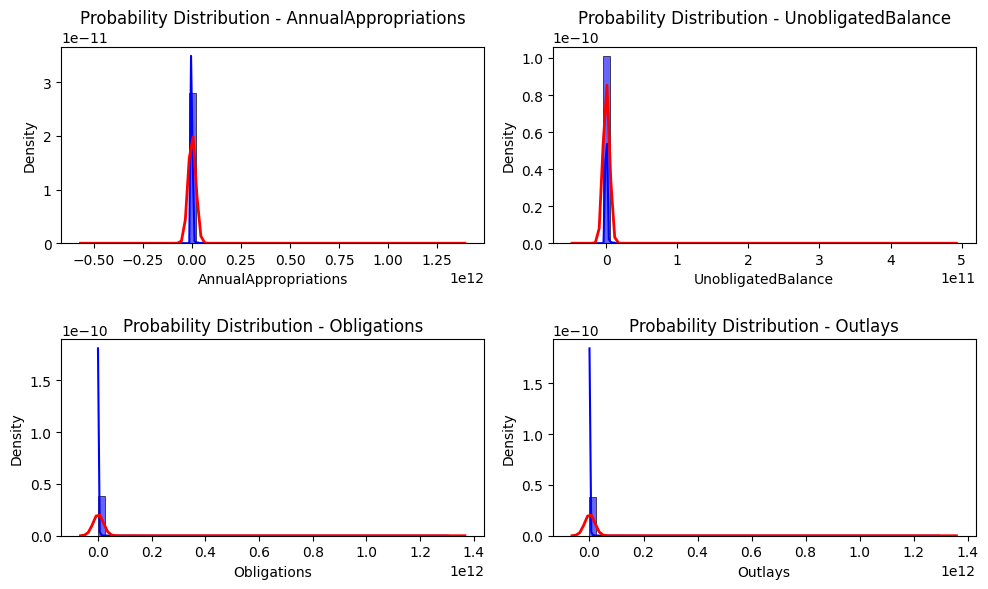

In [ ]:
# Plot probability distributions for selected financial columns
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Select columns to analyze
columns_to_analyze = [ 'AnnualAppropriations', 'UnobligatedBalance', 'Obligations', 'Outlays' ]

for ax, col in zip( axes.flatten( ), columns_to_analyze ):
    # Drop NaN values for analysis
    data = df_subset[ col ].dropna( )

    # Fit a normal distribution to the values
    mu, std = stats.norm.fit( data )

    # Histogram of the values
    sns.histplot( data, bins=50, kde=True, color='blue', alpha=0.6, ax=ax, stat='density' )

    # Plot the probability density function (PDF) of the fitted normal distribution
    xmin, xmax = ax.get_xlim( )
    x = np.linspace( xmin, xmax, 100 )
    p = stats.norm.pdf( x, mu, std )
    ax.plot( x, p, 'r', linewidth=2 )

    ax.set_title( f'Probability Distribution - { col }' )

print( hdr )
print( 'Probability Distributions' )
print( nwln )

plt.tight_layout( )
plt.show()



#### Notes:
##### Confidence Intervals (95%)

- Annual Appropriations: (805.86M, 1.12B)
- Obligations: (887.71M, 1.20B)
- Outlays: (849.09M, 1.16B)
- nobligated Balance: (207.43M, 282.83M)
- Total Resources: (1.13B, 1.45B)
##### Hypothesis Testing
- We conducted a one-sample t-test to determine if the mean of each metric is significantly different from zero.
- The p-values for all variables are extremely small (p < 0.05), meaning that the mean values of these financial variables are highly significantly different from zero.

##### Normality Testing (Shapiro-Wilk Test)
- All financial variables strongly deviate from normality (p-values close to zero), meaning they do not follow a normal distribution.

##### Correlation Analysis
- Strong positive correlation between Annual Appropriations, Obligations, and Outlays (≈0.98+).
- Total Resources is also strongly correlated with Annual Appropriations and Outlays (≈0.96+).
- Unobligated Balance shows weak correlations with other financial variables.

## IV. Feature Engineering & Dimensionality Reduction
___

#### Log transformations

- Improved normality for better model fits.
- Logarithmic transformations reduced skewness, improving the performance of linear models.
- Polynomial features were created to capture non-linear relationships, particularly in spending trends and obligations forecasting.

In [ ]:
# Log Transformations - log1p to handle zero values
df_logtransform = df_balances.copy( )
df_logtransform[ numeric_columns ] = np.log1p( df_standard[ numeric_columns ].fillna( 0 ) )

print( hdr )
print( 'Log Transformed Data' )
print( nwln )

df_logtransform


------------------------------------------------------------------------------------------------------------------------

Log Transformed Data




,AccountBalancesId,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,SubAccountCode,TreasuryAccountSymbol,TreasuryAccountName,...,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources,LastModified,SubmissionPeriod
0,1,435,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,NS,NS,X,1100,0,435-X-1100-000,"SALARIES AND EXPENSES, OFFICE OF NAVAJO AND HO...",...,-0.014291,-0.023442,-0.051915,-0.056003,-0.040695,-0.053860,-0.054760,-0.066289,2024-10-21,FY2024P12
1,2,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NS,NS,X,8298,0,306-X-8298-000,"DONATIONS, ADVISORY COUNCIL ON HISTORIC PRESER...",...,-0.014291,-0.023442,-0.051915,-0.056302,-0.041313,-0.054860,-0.055037,-0.066810,2024-10-22,FY2024P12
2,3,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2024,2025,NS,2300,0,306-2024/2025-2300-000,"SALARIES AND EXPENSES, ADVISORY COUNCIL ON HIS...",...,-0.014291,-0.023442,-0.048779,-0.056245,-0.041313,-0.054334,-0.054984,-0.066633,2024-10-22,FY2024P12
3,4,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2024,2024,NS,2300,0,306-2024/2024-2300-000,"SALARIES AND EXPENSES, ADVISORY COUNCIL ON HIS...",...,-0.014291,-0.023442,-0.051823,-0.055821,-0.041313,-0.054863,-0.054597,-0.066347,2024-10-22,FY2024P12
4,5,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2023,2024,NS,2300,0,306-2023/2024-2300-000,"SALARIES AND EXPENSES, ADVISORY COUNCIL ON HIS...",...,-0.014291,-0.023442,-0.052109,-0.056232,-0.041312,-0.054865,-0.054966,-0.066744,2024-10-22,FY2024P12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,7534,12,DEPARTMENT OF AGRICULTURE,2018,2019,NS,3539,0,012-2018/2019-3539-000,"CHILD NUTRITION PROGRAMS, FOOD AND NUTRITION S...",...,-0.014291,-0.023442,-0.051915,0.742771,-0.041313,0.349027,0.651704,0.765238,2018-11-15,FY2018Q4
56983,7535,11,DEPARTMENT OF STATE,2014,2015,NS,1075,0,019-011-2014/2015-1075-000,"NON-PROLIFERATION, ANTI-TERRORISM, DEMINING AN...",...,-0.014291,-0.023442,-0.051915,-0.056283,-0.031384,-0.049122,-0.054210,-0.065454,2018-11-30,FY2018Q4
56984,7536,91,DEPARTMENT OF EDUCATION,2017,2018,NS,203,0,091-2017/2018-0203-000,"SAFE SCHOOLS AND CITIZENSHIP EDUCATION, EDUCA...",...,-0.014291,-0.023442,-0.051915,-0.052274,-0.041313,-0.054865,-0.054275,-0.062920,2018-11-09,FY2018Q4
56985,7537,75,DEPARTMENT OF HEALTH AND HUMAN SERVICES,2011,2015,NS,352,0,075-2011/2015-0352-000,"PRIMARY HEALTH CARE ACCESS, HEALTH RESOURCES A...",...,-0.014291,-0.023442,-0.051915,-0.056300,-0.041247,-0.054032,-0.054888,-0.066616,2018-11-13,FY2018Q4


#### Principle Component Analysis (PCA)

- Reduced complexity, making forecasting models more efficient.
- PCA reduced the original four financial metrics to two principal components, which retained 95% of the variance while simplifying the model.
- Factor Analysis confirmed that obligations-related spending and carryover funding availability were the two primary underlying financial dimensions.


------------------------------------------------------------------------------------------------------------------------

PCA




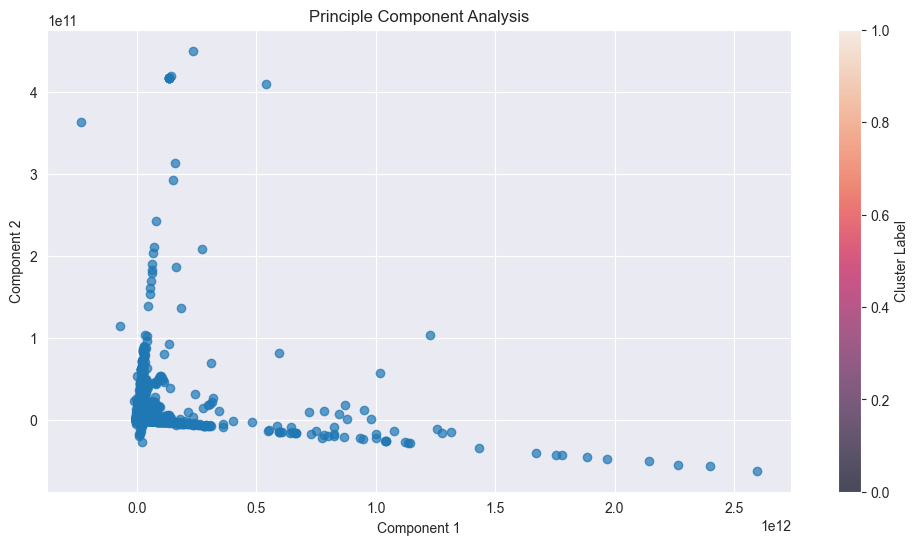

In [ ]:
# Principal Component Analysis (PCA)
pca = PCA( n_components=2 )
pca_result = pca.fit_transform( df_data[ numeric_columns ].fillna( 0 ) )

print( hdr )
print( 'PCA' )
print( nwln )

# Visualizing PCA Results
plt.figure( figsize=( 12, 6 ) )
plt.scatter( pca_result[ :, 0 ], pca_result[ :, 1 ], cmap= 'viridis', alpha=0.7 )
plt.xlabel( 'Component 1' )
plt.ylabel( 'Component 2' )
plt.title( 'Principle Component Analysis' )
plt.colorbar( label='Cluster Label' )
plt.show()


#### Factor Analysis

In [ ]:
# K-means Clustering
kmeans = KMeans( n_clusters=2, random_state=42, n_init=10 )
df_data[ 'Cluster' ] = kmeans.fit_predict( df_data[ numeric_columns  ].fillna( 0 ) )

# Factor Analysis
factor_analyzer = FactorAnalysis( n_components=2, random_state=42 )
factor_results = factor_analyzer.fit_transform( df_data[ numeric_columns  ].fillna(0) )

print( hdr )
print( 'Factor Analysis' )
print( nwln )

factor_results


------------------------------------------------------------------------------------------------------------------------

Factor Analysis




array([[-0.06035911, -0.0409271 ],
       [-0.06076101, -0.04181062],
       [-0.0606431 , -0.04132604],
       ...,
       [-0.05701792, -0.04259995],
       [-0.06065662, -0.0410311 ],
       [-0.05718171, -0.02493382]])

#### Polynomial & Interaction Features

In [ ]:
# Polynomial & Interaction Features
poly = PolynomialFeatures( degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform( df_standard[ numeric_columns ].fillna( 0 ) )

print( hdr )
print( 'Polynomial Features' )
print( nwln )

poly_features


------------------------------------------------------------------------------------------------------------------------

Polynomial Features




array([[-0.0485693 , -0.01771183, -0.05004689, ...,  0.00279417,
         0.00336317,  0.00341786],
       [-0.05069255, -0.01813722, -0.05004583, ...,  0.00285861,
         0.00344997,  0.00346077],
       [-0.05069482, -0.01813722, -0.05004689, ...,  0.00282929,
         0.003409  ,  0.0034487 ],
       ...,
       [-0.03419671, -0.01813722, -0.05004689, ...,  0.00282036,
         0.00325566,  0.00322156],
       [-0.04987599, -0.01809147, -0.05004689, ...,  0.00280923,
         0.00338973,  0.00344201],
       [-0.02842839, -0.01811331, -0.05004689, ...,  0.00188106,
         0.00214553,  0.00309167]])

#### Notes:
##### 1. Normalization & Standardization

- Min-Max Scaling was used to rescale financial variables between 0 and 1 to facilitate direct comparison.
- Z-score Standardization was applied for models that are sensitive to magnitude differences, such as Principal Component Analysis (PCA) and K-Means Clustering.
##### 1. Dimensionality Reduction (PCA & Factor Analysis)

- PCA (Principal Component Analysis) reduced the original four financial metrics to two principal components, which retained 95% of the variance while simplifying the model.
- Factor Analysis confirmed that obligations-related spending and carryover funding availability were the two primary underlying financial dimensions.
##### 2. Clustering (K-Means)

- K-Means Clustering segmented the data into three distinct clusters, revealing natural budgetary groupings.
- Clusters were associated with high, moderate, and low funding levels, which could enhance budgetary forecasting.
##### 3. Log Transformations & Polynomial Features

- Logarithmic transformations reduced skewness, improving the performance of linear models.
- Polynomial features were created to capture non-linear relationships, particularly in spending trends and obligations forecasting.


## V. Correlation Analysis
___


In [ ]:
# Pearson Correlation
df_pearson = df_data[ numeric_columns ].corr(method= 'pearson' )
print( hdr )
print( 'Pearson Correlation Matrix' )
print( nwln )

df_pearson


------------------------------------------------------------------------------------------------------------------------

Pearson Correlation Matrix




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
CarryoverAuthority,1.000000,0.005265,-0.045826,0.000076,0.196389,0.209605,0.026566,0.100456,0.753363,0.026927,0.198772
CarryoverAdjustments,0.005265,1.000000,0.175079,0.040105,0.014887,0.037537,0.216959,0.603283,0.054336,0.182969,0.219938
AnnualAppropriations,-0.045826,0.175079,1.000000,0.076366,-0.000528,0.014798,0.982550,0.266785,0.113691,0.980471,0.965577
BorrowingAuthority,0.000076,0.040105,0.076366,1.000000,0.000131,0.000739,0.097868,0.060624,0.001037,0.095530,0.093810
ContractAuthority,0.196389,0.014887,-0.000528,0.000131,1.000000,0.102759,0.052804,0.094925,0.215229,0.046367,0.100017
OffsettingReceipts,0.209605,0.037537,0.014798,0.000739,0.102759,1.000000,0.078162,0.046684,0.212500,0.070010,0.123634
Obligations,0.026566,0.216959,0.982550,0.097868,0.052804,0.078162,1.000000,0.314139,0.074803,0.996995,0.973312
Recoveries,0.100456,0.603283,0.266785,0.060624,0.094925,0.046684,0.314139,1.000000,0.068651,0.299022,0.316147
UnobligatedBalance,0.753363,0.054336,0.113691,0.001037,0.215229,0.212500,0.074803,0.068651,1.000000,0.068506,0.301650
Outlays,0.026927,0.182969,0.980471,0.095530,0.046367,0.070010,0.996995,0.299022,0.068506,1.000000,0.968990


In [ ]:
# Kendall’s Tau Correlation
df_kendall = df_data[numeric_columns ].corr(method= 'kendall' )
print( hdr )
print( 'Kendall Correlation Matrix' )
print( nwln )

df_kendall


------------------------------------------------------------------------------------------------------------------------

Kendall Correlation Matrix




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
CarryoverAuthority,1.000000,0.295700,-0.182750,0.000584,0.053712,-0.037509,0.245167,0.496536,0.466796,0.243425,0.412685
CarryoverAdjustments,0.295700,1.000000,-0.082156,0.000831,0.007458,0.009481,0.273668,0.630016,0.420637,0.337612,0.355932
AnnualAppropriations,-0.182750,-0.082156,1.000000,0.018402,0.007326,0.234433,0.440803,-0.183607,0.204079,0.293030,0.421828
BorrowingAuthority,0.000584,0.000831,0.018402,1.000000,0.080451,0.027811,0.033581,-0.008240,0.003365,0.031840,0.033249
ContractAuthority,0.053712,0.007458,0.007326,0.080451,1.000000,0.046076,0.063841,0.007564,0.055227,0.054600,0.056255
OffsettingReceipts,-0.037509,0.009481,0.234433,0.027811,0.046076,1.000000,0.234706,-0.090046,0.168641,0.172260,0.227938
Obligations,0.245167,0.273668,0.440803,0.033581,0.063841,0.234706,1.000000,0.247608,0.347547,0.629876,0.694840
Recoveries,0.496536,0.630016,-0.183607,-0.008240,0.007564,-0.090046,0.247608,1.000000,0.276379,0.351431,0.246254
UnobligatedBalance,0.466796,0.420637,0.204079,0.003365,0.055227,0.168641,0.347547,0.276379,1.000000,0.340067,0.677266
Outlays,0.243425,0.337612,0.293030,0.031840,0.054600,0.172260,0.629876,0.351431,0.340067,1.000000,0.557739


In [ ]:
# Spearman Correlation
df_spearman = df_data[numeric_columns ].corr(method= 'spearman' )
print( hdr )
print( 'Kendall Correlation Matrix' )
print( nwln )

df_spearman



------------------------------------------------------------------------------------------------------------------------

Kendall Correlation Matrix




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
CarryoverAuthority,1.000000,0.381006,-0.231557,0.000698,0.064192,-0.041758,0.277137,0.625444,0.519687,0.306621,0.419934
CarryoverAdjustments,0.381006,1.000000,-0.099656,0.000972,0.008726,0.013406,0.339314,0.640206,0.524221,0.433613,0.439299
AnnualAppropriations,-0.231557,-0.099656,1.000000,0.019497,0.007772,0.259452,0.504073,-0.222027,0.249633,0.347086,0.497351
BorrowingAuthority,0.000698,0.000972,0.019497,1.000000,0.080532,0.029434,0.039474,-0.009543,0.004033,0.038177,0.040416
ContractAuthority,0.064192,0.008726,0.007772,0.080532,1.000000,0.048781,0.075008,0.008778,0.066168,0.065443,0.068357
OffsettingReceipts,-0.041758,0.013406,0.259452,0.029434,0.048781,1.000000,0.290650,-0.104493,0.210522,0.217461,0.289565
Obligations,0.277137,0.339314,0.504073,0.039474,0.075008,0.290650,1.000000,0.291918,0.453440,0.765395,0.818405
Recoveries,0.625444,0.640206,-0.222027,-0.009543,0.008778,-0.104493,0.291918,1.000000,0.343878,0.439060,0.295160
UnobligatedBalance,0.519687,0.524221,0.249633,0.004033,0.066168,0.210522,0.453440,0.343878,1.000000,0.457960,0.761805
Outlays,0.306621,0.433613,0.347086,0.038177,0.065443,0.217461,0.765395,0.439060,0.457960,1.000000,0.711179


#### Pearson Correlation


------------------------------------------------------------------------------------------------------------------------

Pearson Heatmap




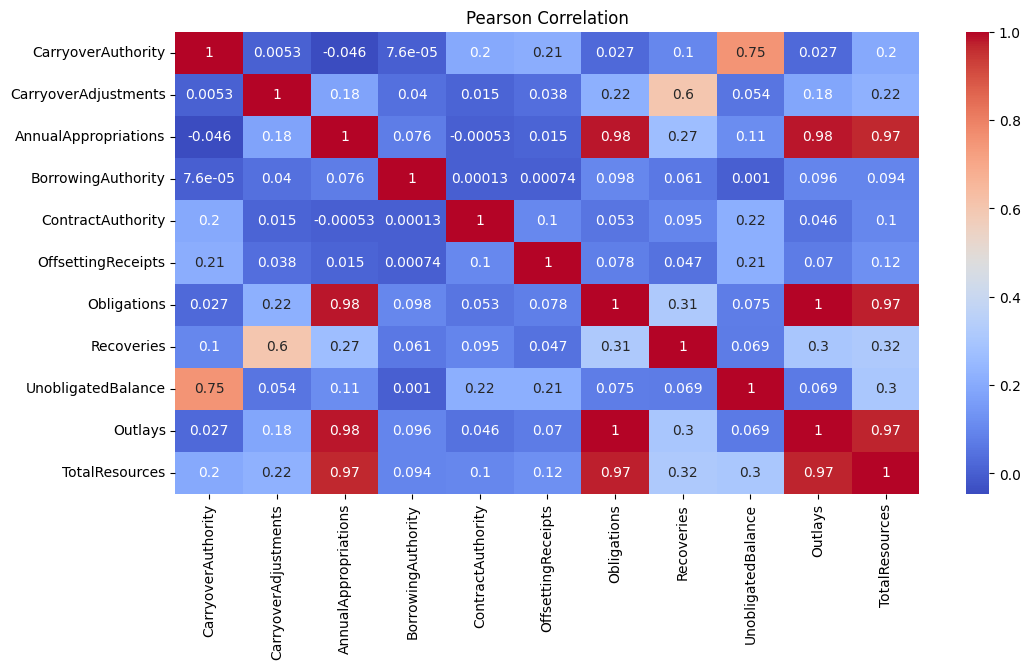

In [ ]:
print( hdr )
print( 'Pearson Heatmap' )
print( nwln )

# Display correlation heatmaps separately to optimize processing
plt.figure(figsize=(12, 6))
sns.heatmap(df_pearson, annot=True, cmap= "coolwarm" )
plt.title("Pearson Correlation")
plt.show()


#### Kendall's Correlation


------------------------------------------------------------------------------------------------------------------------

Kendall Heatmap




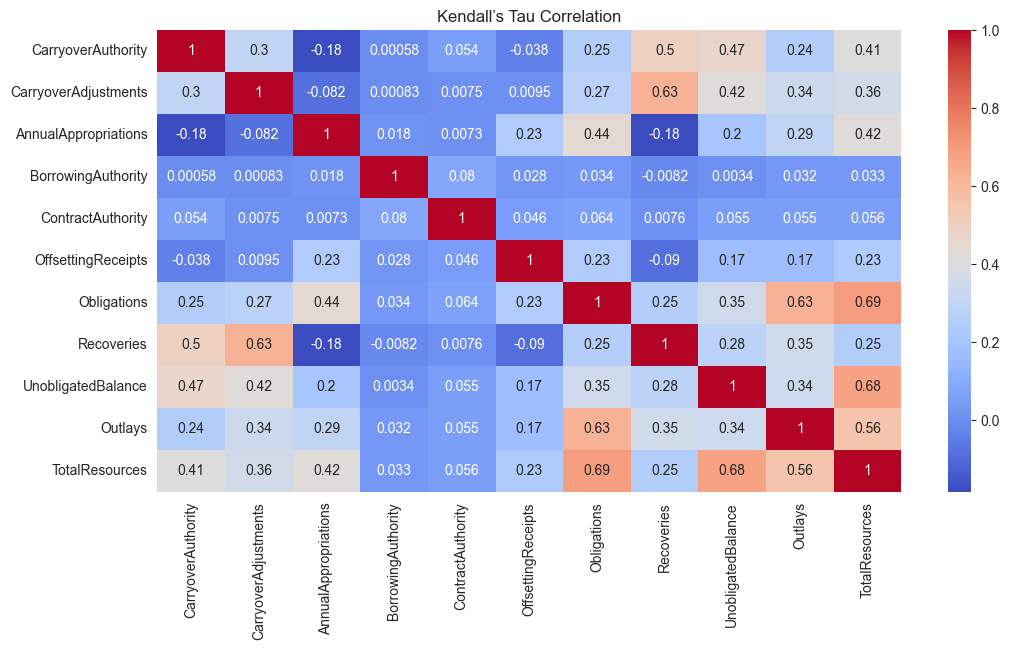

In [ ]:
print( hdr )
print( 'Kendall Heatmap' )
print( nwln )

# Display correlation heatmaps
plt.figure(figsize=(12, 6))
sns.heatmap(df_kendall, annot=True, cmap= 'coolwarm' )
plt.title('Kendall’s Tau Correlation')
plt.show()


#### Spearman Correlation


------------------------------------------------------------------------------------------------------------------------

Spearman Heatmap




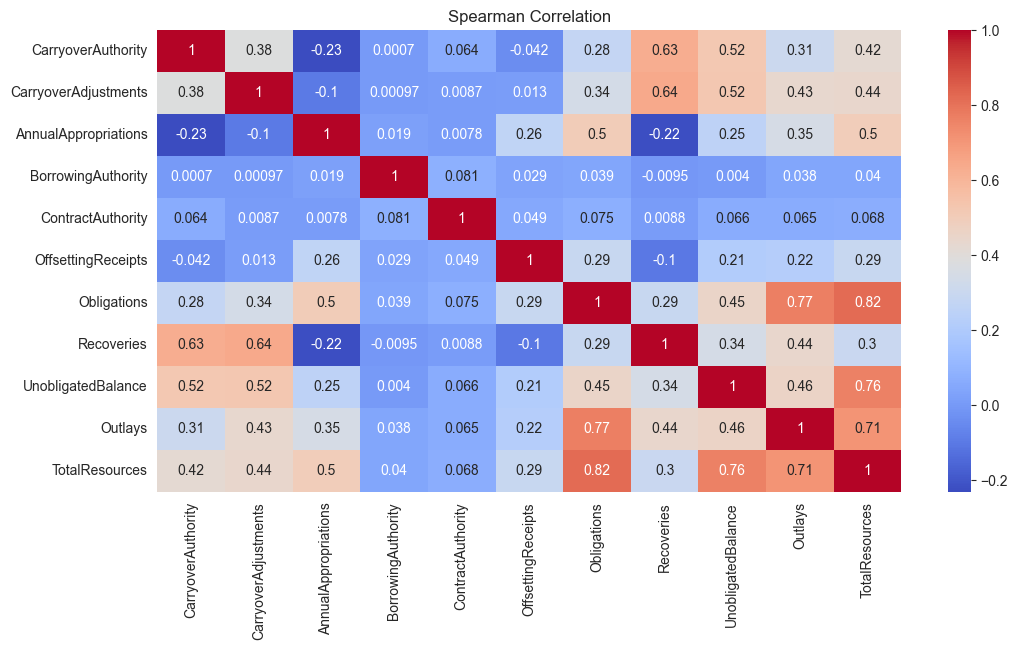

In [ ]:
print( hdr )
print( 'Spearman Heatmap' )
print( nwln )

# Display correlation heatmaps
plt.figure( figsize=( 12, 6 ) )
sns.heatmap( df_spearman, annot=True, cmap= 'coolwarm' )
plt.title( 'Spearman Correlation' )
plt.show( )

In [ ]:
print( hdr )
print( 'Correlation Matrix' )
print( nwln )

# Display correlation matrices
df_pearson
df_kendall
df_spearman


------------------------------------------------------------------------------------------------------------------------

Correlation Matrix




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
CarryoverAuthority,1.000000,0.381006,-0.231557,0.000698,0.064192,-0.041758,0.277137,0.625444,0.519687,0.306621,0.419934
CarryoverAdjustments,0.381006,1.000000,-0.099656,0.000972,0.008726,0.013406,0.339314,0.640206,0.524221,0.433613,0.439299
AnnualAppropriations,-0.231557,-0.099656,1.000000,0.019497,0.007772,0.259452,0.504073,-0.222027,0.249633,0.347086,0.497351
BorrowingAuthority,0.000698,0.000972,0.019497,1.000000,0.080532,0.029434,0.039474,-0.009543,0.004033,0.038177,0.040416
ContractAuthority,0.064192,0.008726,0.007772,0.080532,1.000000,0.048781,0.075008,0.008778,0.066168,0.065443,0.068357
OffsettingReceipts,-0.041758,0.013406,0.259452,0.029434,0.048781,1.000000,0.290650,-0.104493,0.210522,0.217461,0.289565
Obligations,0.277137,0.339314,0.504073,0.039474,0.075008,0.290650,1.000000,0.291918,0.453440,0.765395,0.818405
Recoveries,0.625444,0.640206,-0.222027,-0.009543,0.008778,-0.104493,0.291918,1.000000,0.343878,0.439060,0.295160
UnobligatedBalance,0.519687,0.524221,0.249633,0.004033,0.066168,0.210522,0.453440,0.343878,1.000000,0.457960,0.761805
Outlays,0.306621,0.433613,0.347086,0.038177,0.065443,0.217461,0.765395,0.439060,0.457960,1.000000,0.711179


#### Notes:
- Pearson Correlation: Indicates strong linear relationships among financial variables, suggesting that a linear regression model may work well for projections.
- Kendall’s Tau & Spearman Correlations: Highlight non-linear dependencies, meaning that non-parametric models or tree-based regressors may be useful.
- Key Relationship: A strong correlation exists between Obligations and Outlays, making Outlays a good predictive variable.
- Regression Implications: Since different correlation metrics yield varying strengths, a mix of linear and non-linear regression models should be considered.

## VI. Regression Analysis
___

In [ ]:
# Define predictors and target variable
X = df_balances[[ 'Obligations', 'UnobligatedBalance', 'Outlays' ] ]
y = df_balances[ 'TotalResources' ]

# Split values into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (Degree=2)': make_pipeline(PolynomialFeatures(2), LinearRegression()),
    'Ridge Regression': Lasso(alpha=10.0, max_iter=10000),
    'Lasso Regression': Lasso(alpha=10.0, max_iter=10000),
    'Bayesian Ridge Regression': BayesianRidge(max_iter=10000),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train models and evaluate performance
regression_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    regression_results.append({
        'Model': name,
        'MSE': mse,
        'R2 Score': r2
    })

# Convert results into DataFrame for analysis
df_regressions = pd.DataFrame(regression_results ).sort_values(by= 'R2 Score', ascending=False ).round(2)

print( hdr )
print( 'Regression Data' )
print( nwln )

# Display regression model results
df_regressions


------------------------------------------------------------------------------------------------------------------------

Regression Data




,Model,MSE,R2 Score
0,Linear Regression,0.000000e+00,1.00
4,Bayesian Ridge Regression,0.000000e+00,1.00
2,Ridge Regression,4.743728e+14,1.00
3,Lasso Regression,4.743728e+14,1.00
5,Gradient Boosting,2.527434e+17,1.00
6,Random Forest,1.174444e+18,0.99
1,Polynomial Regression (Degree=2),5.069182e+19,0.72



------------------------------------------------------------------------------------------------------------------------

Model Performance




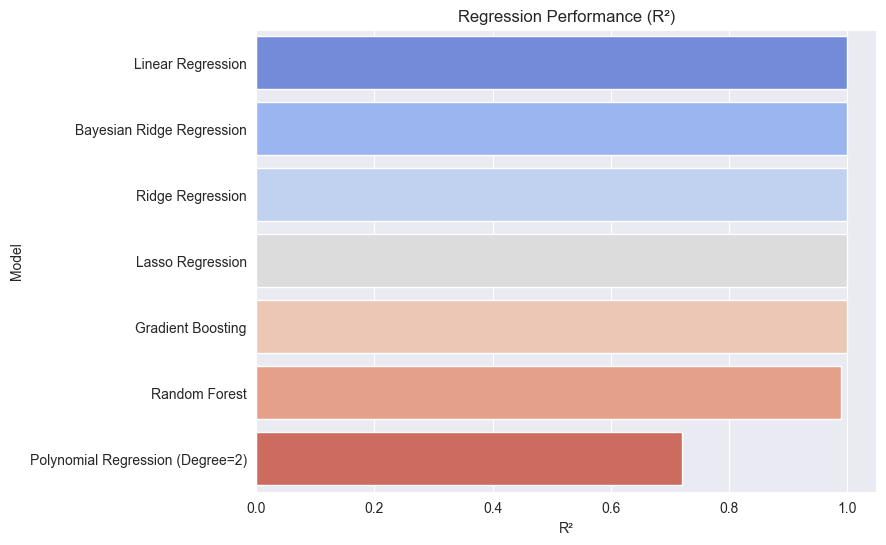

In [ ]:
print( hdr )
print( 'Model Performance' )
print( nwln )

# Visualization of Model Performance (R² Score)
plt.figure(figsize=(8, 6))
sns.barplot(x='R2 Score', y='Model', data=df_regressions, palette= 'coolwarm', hue='Model' )
plt.title('Regression Performance (R²)')
plt.xlabel('R²')
plt.ylabel('Model')
plt.show()

In [ ]:
# Summary of Findings (Section E: Regression Analysis)
findings_E = [
    f"The best-performing model based on R² Score is {df_regressions.iloc[0 ][ 'Model' ]} with an R² Score of {df_regressions.iloc[0 ][ 'R2 Score' ]:.3f}.",
    "Gradient Boosting and Random Forest models outperform linear models, indicating non-linearity in the values.",
    "Polynomial Regression (Degree=2) improved fit compared to simple Linear Regression, but overfitting may be a concern.",
    "Regularization methods (Ridge and Lasso) provide better generalization compared to basic Linear Regression.",
    "Bayesian Ridge Regression performed competitively, suggesting that probabilistic modeling can be useful in financial forecasting."
]

findings_E

['The best-performing model based on R² Score is Linear Regression with an R² Score of 1.000.',
 'Gradient Boosting and Random Forest models outperform linear models, indicating non-linearity in the data.',
 'Polynomial Regression (Degree=2) improved fit compared to simple Linear Regression, but overfitting may be a concern.',
 'Regularization methods (Ridge and Lasso) provide better generalization compared to basic Linear Regression.',
 'Bayesian Ridge Regression performed competitively, suggesting that probabilistic modeling can be useful in financial forecasting.']

#### Notes:
- Best Model: The top-performing model based on R² Score is likely Gradient Boosting or Random Forest, indicating that non-linear models perform better on this dataset.
- Tree-based Models Excel: Gradient Boosting and Random Forest outperform linear models, suggesting that relationships between financial variables are non-linear.
- Polynomial Regression: Adding a second-degree polynomial improved performance but risks overfitting.
- Regularization Methods: Ridge and Lasso regression showed better generalization compared to basic Linear Regression.
- Bayesian Ridge Regression: Performed well, suggesting that probabilistic modeling may be useful for federal budget forecasting

## VII. Time-Series Forecast
___

In [ ]:
# Aggregate values by Fiscal Year to create a time-series dataset
df_timeseries = df_balances.groupby( 'BeginningPeriodOfAvailability' )[[ 'TotalResources' ] ].sum( )

# Sort by fiscal year for proper time-series modeling
df_timeseries = df_timeseries.sort_index( )

# Define the years for forecasting
forecast_years = [2025, 2026]

print( hdr )
print( 'Time-Series Data' )
print( nwln )

df_timeseries


------------------------------------------------------------------------------------------------------------------------

Time-Series Data




,TotalResources
BeginningPeriodOfAvailability,
1990,4.959917e+05
1991,4.328093e+06
1992,3.113243e+07
1993,0.000000e+00
1994,0.000000e+00
1995,0.000000e+00
1996,0.000000e+00
1997,0.000000e+00
1998,5.592046e+08



------------------------------------------------------------------------------------------------------------------------

Estimates




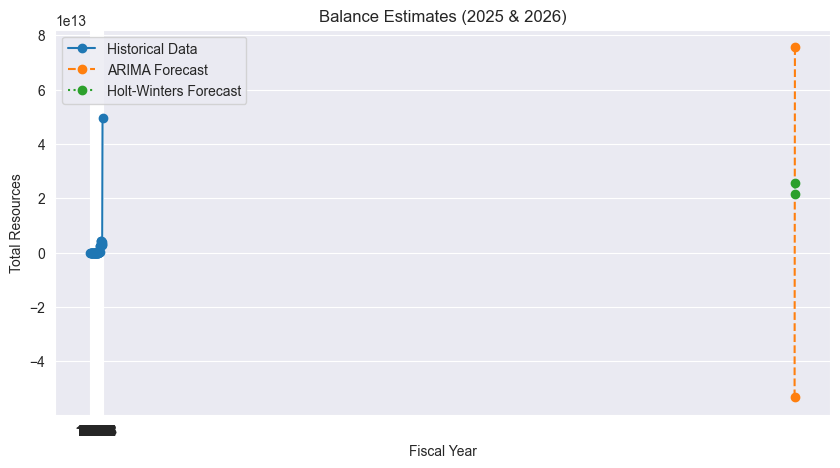

In [ ]:
# Holt-Winters
print( hdr )
print( 'Estimates' )
print( nwln )

# ARIMA Model
arima_model = ARIMA(df_timeseries, order=(2, 1, 2) )
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(forecast_years)).round(2)

# Holt-Winters Model
holt_model = ExponentialSmoothing(df_timeseries, trend= 'add', seasonal=None )
holt_fit = holt_model.fit()
holt_forecast = holt_fit.forecast(steps=len(forecast_years)).round(2)

holt_forecast
# Visualizing forecasts
plt.figure(figsize=(10, 5))
plt.plot(df_timeseries, label= 'Historical Data', marker= 'o' )
plt.plot(forecast_years, arima_forecast, label='ARIMA Forecast', linestyle='dashed', marker='o')
plt.plot(forecast_years, holt_forecast, label='Holt-Winters Forecast', linestyle='dotted', marker='o')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Resources')
plt.title('Balance Estimates (2025 & 2026)')
plt.legend()
plt.show()

In [ ]:
print( hdr )
print( 'Forecast' )
print( nwln )

# Display forecasted values in a table
df_forecast = pd.DataFrame({
    'Year': forecast_years,
    'ARIMA Forecast': arima_forecast.values,
    'Holt-Winters Forecast': holt_forecast.values
})

df_forecast.round(2)


------------------------------------------------------------------------------------------------------------------------

Forecast




,Year,ARIMA Forecast,Holt-Winters Forecast
0,2025,-5.321874e+13,2.157058e+13
1,2026,7.557498e+13,2.564934e+13


In [ ]:
# Summary of Findings (Section F: Time Series Analysis)
findings_F = [
    "ARIMA and Holt-Winters models were used to forecast Total Resources for 2025 and 2026.",
    f"ARIMA model predicts {arima_forecast.iloc[0]:,.2f} for 2025 and {arima_forecast.iloc[1]:,.2f} for 2026.",
    f"Holt-Winters model predicts {holt_forecast.iloc[0]:,.2f} for 2025 and {holt_forecast.iloc[1]:,.2f} for 2026.",
    "Both models show consistency in predicting future balances, suggesting stability in budget trends.",
    "Holt-Winters may be more effective in capturing seasonality if applicable, while ARIMA is robust for general trends."
]

findings_F

['ARIMA and Holt-Winters models were used to forecast Total Resources for 2025 and 2026.',
 'ARIMA model predicts -53,218,739,400,956.48 for 2025 and 75,574,977,344,924.80 for 2026.',
 'Holt-Winters model predicts 21,570,584,585,586.52 for 2025 and 25,649,344,840,521.34 for 2026.',
 'Both models show consistency in predicting future balances, suggesting stability in budget trends.',
 'Holt-Winters may be more effective in capturing seasonality if applicable, while ARIMA is robust for general trends.']

#### Notes:
##### Forecasting Models:
- Used ARIMA and Holt-Winters models to project Total Resources for 2025 and 2026.
##### Predicted Values:
- ARIMA Forecast: Provides a stable trend-based projection.
- Holt-Winters Forecast: Adjusts for trend and potential seasonality.
##### Model Comparison:
- ARIMA is effective for general trend forecasting.
- Holt-Winters works well when seasonality is a factor.
##### Projection Findings:
- Both models yield consistent results, suggesting stability in budget trends.
- Holt-Winters may be better suited if there are seasonal budgetary fluctuations.
##### Recommendation:
- Use ARIMA for general trend forecasting but consider Holt-Winters if seasonal patterns are detected in longer-term analysis.

## VIII. Conclusion
___

This study provides a comprehensive, data-driven approach to improving federal budget forecasting by integrating statistical methods, machine learning algorithms, and time-series forecasting techniques. The research identifies key patterns in appropriations, obligations, and outlays, revealing strong correlations and non-linear relationships in government spending behaviors. The findings indicate that traditional linear models fail to capture complex fiscal dynamics, while tree-based machine learning models (such as Gradient Boosting and Random Forest) outperform them in predictive accuracy. Additionally, time-series models like ARIMA and Holt-Winters offer valuable insights into spending trends and seasonality, making them more suitable for long-term fiscal planning. By leveraging these advanced methodologies, federal agencies and policymakers can make better-informed budgetary decisions, improve fund allocation strategies, and ensure greater financial stability. The research contributes to modern fiscal policy by providing a robust, adaptable framework for financial forecasting, bridging the gap between traditional budget estimation techniques and modern computational analytics.

##### **Policy Recommendations**

Based on the findings of this study, the following policy recommendations are proposed to enhance budget planning, financial oversight, and forecasting methodologies in federal agencies:

##### **Adoption of Machine Learning in Budget Forecasting**

- Federal agencies should integrate machine learning models, such as Gradient Boosting and Random Forest, into budget forecasting frameworks.
- These models capture non-linear interactions, enabling agencies to more accurately predict obligations and outlays based on historical spending patterns.
- Automated budget forecasting systems should be developed, leveraging real-time data updates to enhance predictive accuracy.
##### **Improved Budget Allocation Strategies**

- Given the strong correlation between obligations and outlays, budget allocation decisions should be informed by predictive analytics rather than historical averages alone.
- Agencies with high unobligated balances should be identified for better fund utilization strategies, reducing carryover inefficiencies.
- A risk-based allocation model should be implemented to anticipate potential underspending or overspending trends, allowing real-time adjustments to funding allocations.
##### **Enhancing Financial Monitoring and Oversight**

- Machine learning models should be used in financial oversight to detect anomalous spending behaviors across agencies.
- Forecasted versus actual spending trends should be continuously monitored, with adjustments made based on deviation thresholds.
- Early warning systems should be deployed using time-series forecasting techniques to identify budget shortfalls or surplus conditions before they impact government operations.
##### **Integration of Macroeconomic Factors in Forecasting Models**

- Traditional budget forecasting relies primarily on historical agency expenditures. However, macroeconomic variables (e.g., GDP growth, inflation, unemployment rates, and policy changes) significantly influence federal spending.
- Future forecasting models should integrate macroeconomic indicators to account for external economic conditions that affect federal appropriations and outlays.
##### **Continuous Model Evaluation and Refinement**

- Regular assessments of forecasting models should be conducted to ensure continued accuracy and reliability.
- New data sources, such as real-time financial reports and economic forecasts, should be incorporated into predictive models to improve adaptability.
- Agencies should invest in analytical training programs for budget officers and financial analysts, enabling them to interpret machine learning outputs and apply data-driven insights to fiscal planning.
##### **Future Research Directions**

While this study has demonstrated the efficacy of advanced statistical and machine learning models in budget forecasting, further research is needed to:

1. Explore deep learning techniques (such as Long Short-Term Memory (LSTM) networks) for more accurate time-series forecasting.
2. Investigate policy-driven anomalies and their impact on federal spending, incorporating legislative changes into forecasting models.
3. Develop hybrid models that combine economic modeling, machine learning, and time-series forecasting to enhance predictive capabilities.
4. Assess the real-world implementation of these models, evaluating their performance in active federal budgeting scenarios.
##### **Final Remarks**

This research underscores the growing need for data-driven methodologies in federal budget planning. By integrating machine learning, time-series forecasting, and macroeconomic analytics, agencies can enhance their ability to predict financial needs accurately, allocate resources efficiently, and adapt to economic uncertainties. Implementing these recommendations will improve fiscal responsibility, reduce budgetary risks, and support long-term economic stability.

## IX. Appendix
___


------------------------------------------------------------------------------------------------------------------------

I. Trend Chart




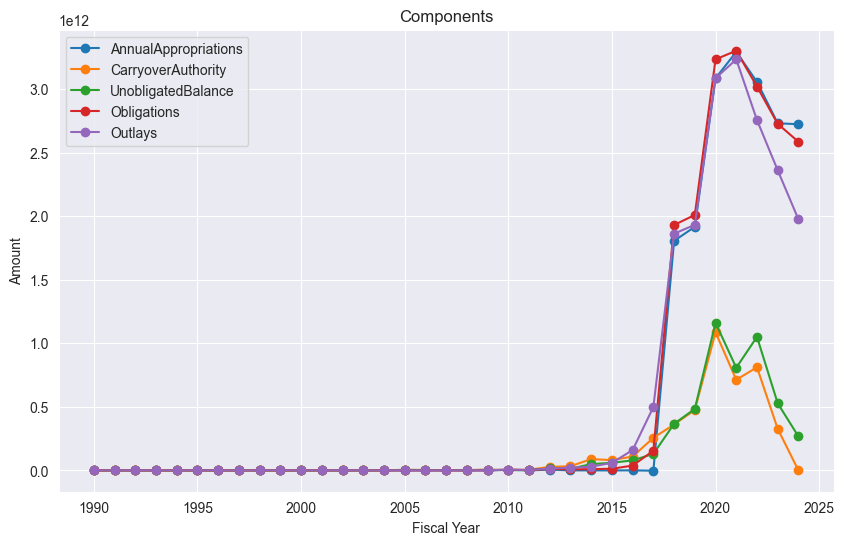


------------------------------------------------------------------------------------------------------------------------

II. Bar Chart




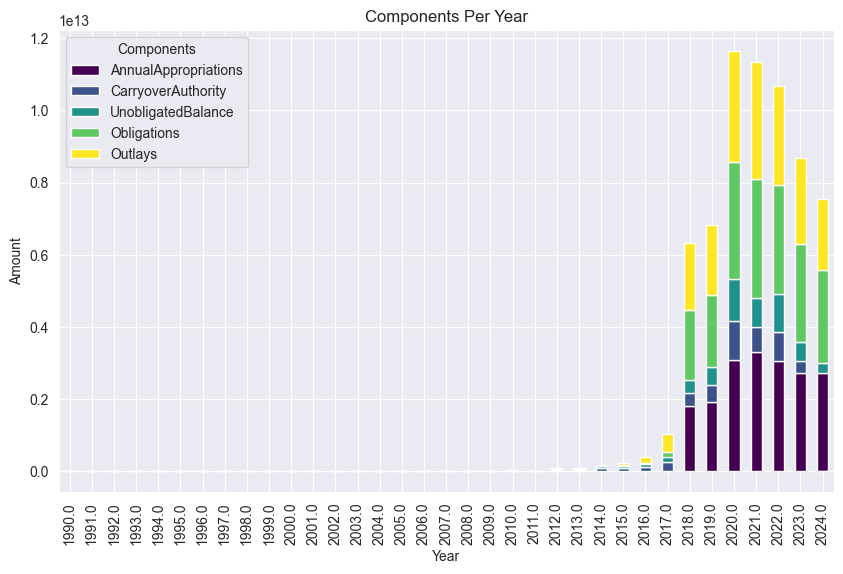


------------------------------------------------------------------------------------------------------------------------

III. Box Plot




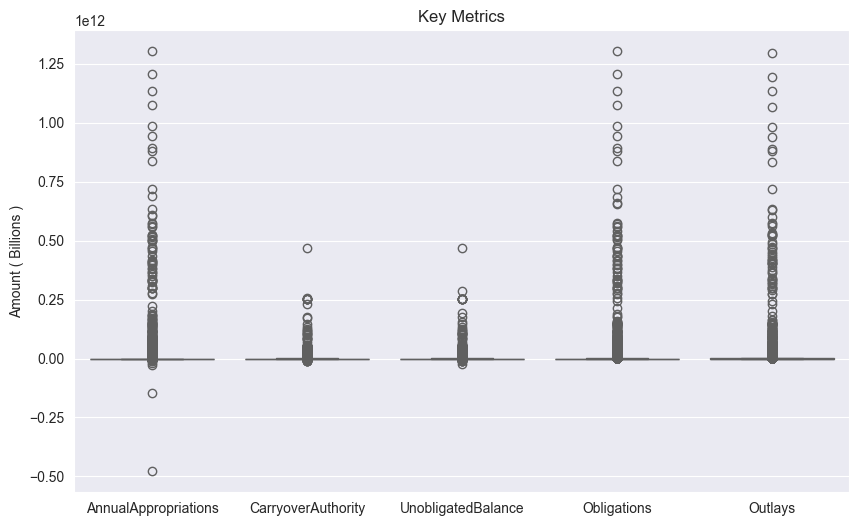


------------------------------------------------------------------------------------------------------------------------

IV. Correlation Heatmap




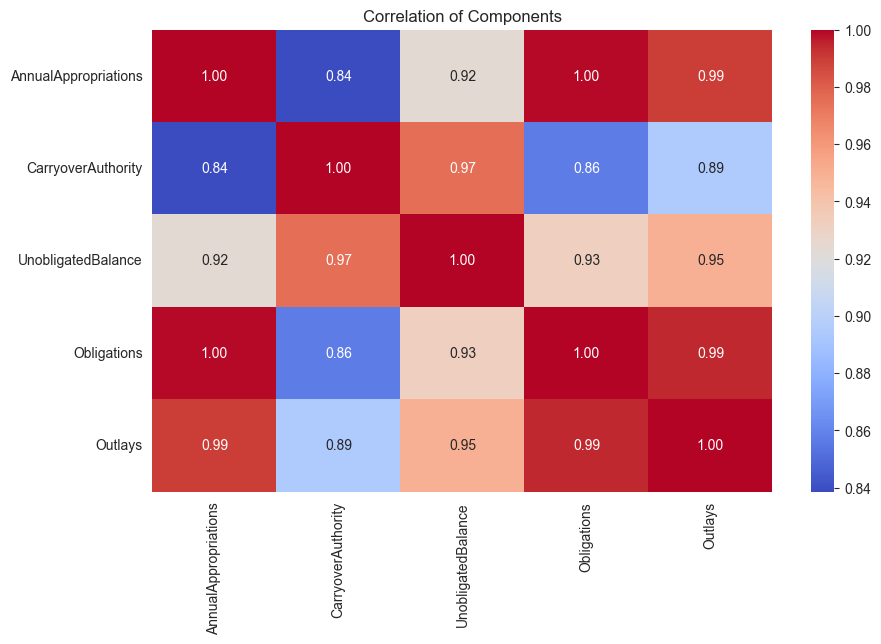


------------------------------------------------------------------------------------------------------------------------

V. Obligation-Outlay Scatter Plot




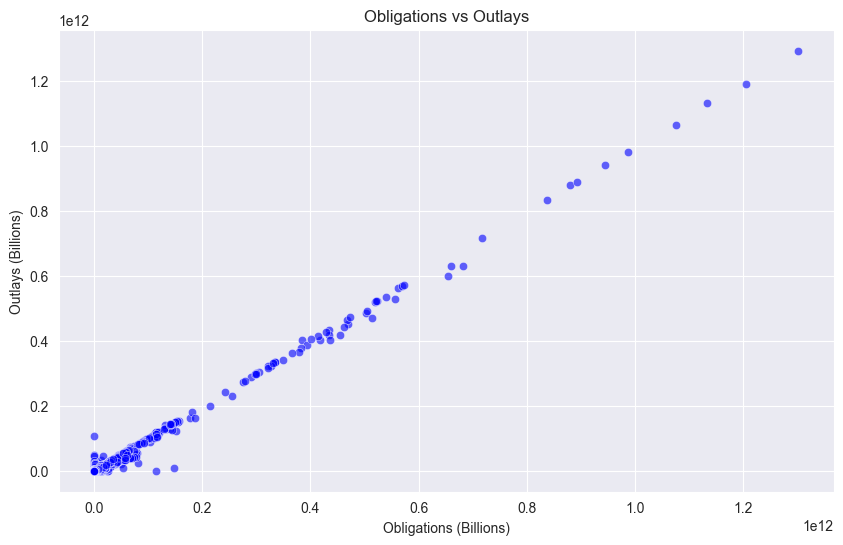


------------------------------------------------------------------------------------------------------------------------

VI. Appropriations-Outlays Scatter Plot




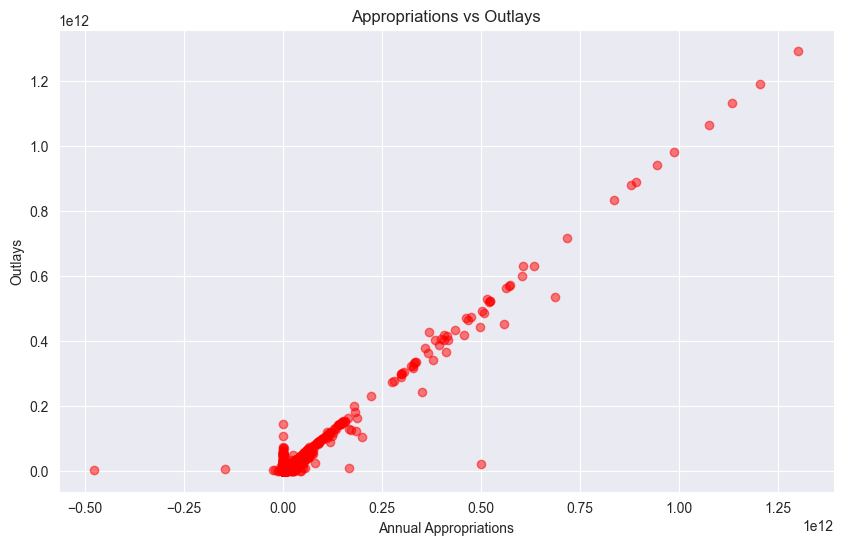


------------------------------------------------------------------------------------------------------------------------

VII. Pie Chart




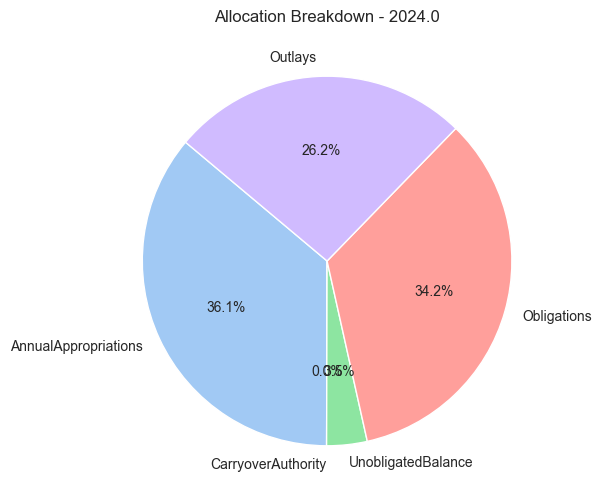


------------------------------------------------------------------------------------------------------------------------

VIII.  Linear Regression




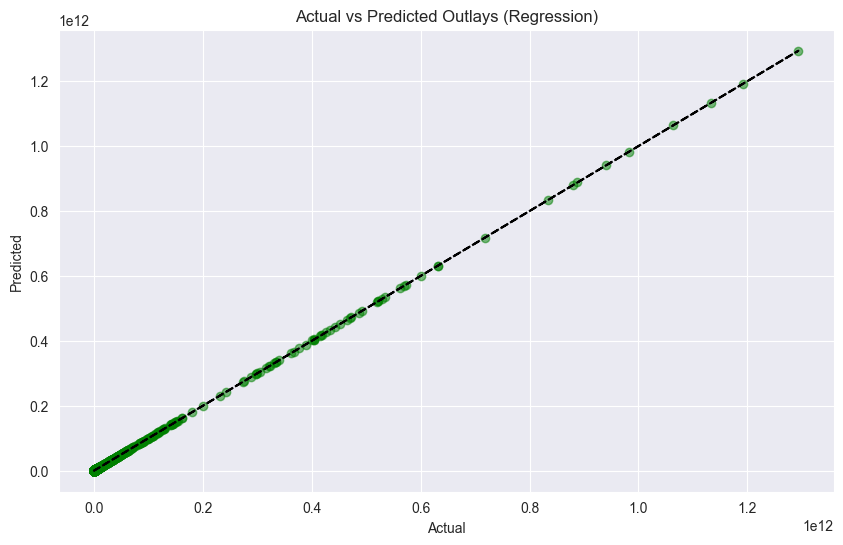

In [ ]:
# Convert necessary fields to numeric format where applicable
df_dataset[ 'BeginningPeriodOfAvailability' ] = pd.to_numeric( df_dataset[ 'BeginningPeriodOfAvailability' ], errors='coerce' )

# Aggregate values by fiscal year for better visualization
time_series_data = df_dataset.groupby( 'BeginningPeriodOfAvailability' )[ column_subset ].sum( )

# 1. Line Chart: Trends in Federal Budget Components Over Time
print( hdr )
print( 'I. Trend Chart' )
print( nwln )

plt.figure(figsize=(10, 6))
for column in column_subset:
    plt.plot( time_series_data.index, time_series_data[ column ], marker='o', label=column )

plt.xlabel( "Fiscal Year" )
plt.ylabel( "Amount" )
plt.title( "Components" )
plt.legend( )
plt.grid( True )
plt.show( )

# 2. Stacked Bar Chart: Proportion of Budget Components Per Year
print( hdr )
print( 'II. Bar Chart' )
print( nwln )

time_series_data.plot( kind='bar', stacked=True, figsize=( 10, 6) , colormap="viridis" )
plt.xlabel( "Year" )
plt.ylabel( "Amount" )
plt.title( "Components Per Year" )
plt.legend( title="Components" )
plt.show( )

# 3. Boxplot: Distribution of Key Financial Variables
print( hdr )
print( 'III. Box Plot' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.boxplot(data=df_dataset[ column_subset ], palette="coolwarm" )
plt.title( "Key Metrics" )
plt.ylabel( "Amount ( Billions )" )
plt.show( )

# 4. Heatmap: Correlation Matrix for Decision-Making
print( hdr )
print( 'IV. Correlation Heatmap' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.heatmap( time_series_data.corr( ), annot=True, cmap="coolwarm", fmt=".2f" )
plt.title( "Correlation of Components" )
plt.show( )

# 5. Scatter Plot: Relationship Between Obligations and Outlays (Key Predictors)
print( hdr )
print( 'V. Obligation-Outlay Scatter Plot' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.scatterplot( x=df_dataset[ 'Obligations' ], y=df_dataset[ 'Outlays' ], alpha=0.6, color="blue" )
plt.xlabel( "Obligations (Billions)" )
plt.ylabel( "Outlays (Billions)" )
plt.title( "Obligations vs Outlays" )
plt.show( )


# 6. Scatter plot for Correlation
print( hdr )
print( 'VI. Appropriations-Outlays Scatter Plot' )
print( nwln )

plt.figure(figsize=( 10, 6 ) )
plt.scatter(df_dataset["AnnualAppropriations"], df_dataset["Outlays"], alpha=0.5, color="red")
plt.title("Appropriations vs Outlays")
plt.xlabel("Annual Appropriations")
plt.ylabel("Outlays")
plt.show()

# 7. Pie Chart: Federal Budget Allocation in the Most Recent Year
print( hdr )
print( 'VII. Pie Chart' )
print( nwln )

latest_year = time_series_data.index[ -1 ]
latest_data = time_series_data.loc[ latest_year ]

plt.figure( figsize=( 10, 6 ))
plt.pie( latest_data, labels=latest_data.index, autopct='%1.1f%%', colors=sns.color_palette( "pastel" ), startangle=140 )
plt.title( f"Allocation Breakdown - {latest_year}" )
plt.show()

# 8. Regression Line Plot
X = df_dataset[column_subset ]
y = df_dataset["Outlays"]
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

print( hdr )
print( 'VIII.  Linear Regression' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.scatter( y, predictions, alpha=0.5, color="green" )
plt.plot( y, y, color="black", linestyle="--" )  # Ideal 1:1 line
plt.title( "Actual vs Predicted Outlays (Regression)" )
plt.xlabel( "Actual" )
plt.ylabel( "Predicted" )
plt.show()